In [1]:
# import functions from ../definitions/definitions_EDA
from datetime import timedelta
import sys
from matplotlib import pyplot as plt
import pandas as pd
from prophet import Prophet
import numpy as np
sys.path.append('../definitions')
import definitions_EDA as eda
# import definitions_plotting as def_plot
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import shutil
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from scipy.signal import find_peaks
from prophet.plot import plot_plotly, plot_components_plotly
import gc


Define Variables

In [18]:
start_date = '2024-03-20'
end_date = '2024-04-01'

Fetch data and store as dataframe (data ingestion)

The total number of duplicates is: 1143822
 
Number of days data = Total records 5360014 / records per day (431998) = 12.407497256931745 
 
Head of dataframe: 
                           NS_SQUID  Z_SQUID   NS_Fluxgate  EW_Fluxgate    Z_Fluxgate
2024-03-21 15:15:10.540 -17.244301   0.3012  10934.280273   -42.408699 -22656.423828
2024-03-21 15:15:10.740 -17.241400   0.3024  10934.269531   -42.417099 -22656.427734
2024-03-21 15:15:10.940 -17.235201   0.2902  10934.269531   -42.417099 -22656.427734
2024-03-21 15:15:11.140 -17.238899   0.2985  10934.265625   -42.418201 -22656.431641
2024-03-21 15:15:11.340 -17.233801   0.2598  10934.259766   -42.377201 -22656.437500


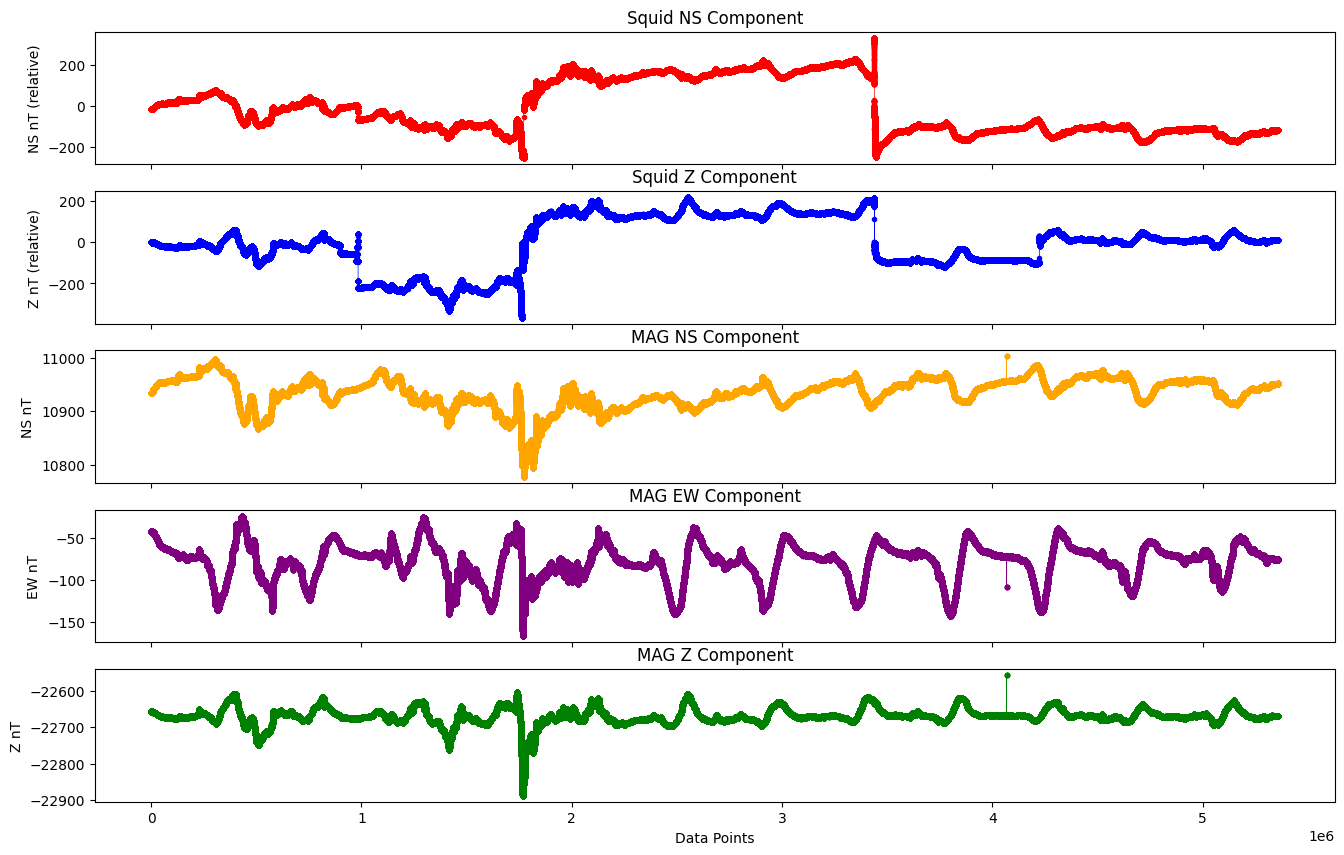

In [20]:
data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date, end_date))
data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date, end_date))
df = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date)
df = df.astype({'NS_SQUID': 'float32', 'Z_SQUID': 'float32', 'NS_Fluxgate': 'float32', 'EW_Fluxgate': 'float32', 'Z_Fluxgate': 'float32'})
del data_arr_mag, data_arr_squid
gc.collect()
# df = df.between_time('12:30:00', '13:30:00') # Select only a small subset of the data for analysis
# print(f' \n Shape of df', df.shape)
print(f' \nNumber of days data = Total records {df.shape[0]} / records per day (431998) = {df.shape[0]/431998} ')
print(f' \nHead of dataframe: \n', df.head().to_string(index=True))
eda.generateDataPlots(df['NS_SQUID'].values, df['Z_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 431997, start_date, end_date)


# Scale SQUID data

Determine the Offset (Baseline)

Define Quiet Period

The total number of duplicates is: 369964
 
Number of days data = Total records 2591984 / records per day (431998) = 5.999990740697873 
 
Head of dataframe: 
                            NS_SQUID     Z_SQUID   NS_Fluxgate  EW_Fluxgate    Z_Fluxgate
2024-03-26 00:00:00.170  162.668396  133.790497  10925.593750   -84.336098 -22677.361328
2024-03-26 00:00:00.370  162.673294  133.796799  10925.596680   -84.352898 -22677.365234
2024-03-26 00:00:00.570  162.682999  133.804001  10925.596680   -84.352898 -22677.365234
2024-03-26 00:00:00.770  162.684402  133.811203  10925.598633   -84.560799 -22677.175781
2024-03-26 00:00:00.970  162.685303  133.826706  10925.598633   -84.560799 -22677.175781


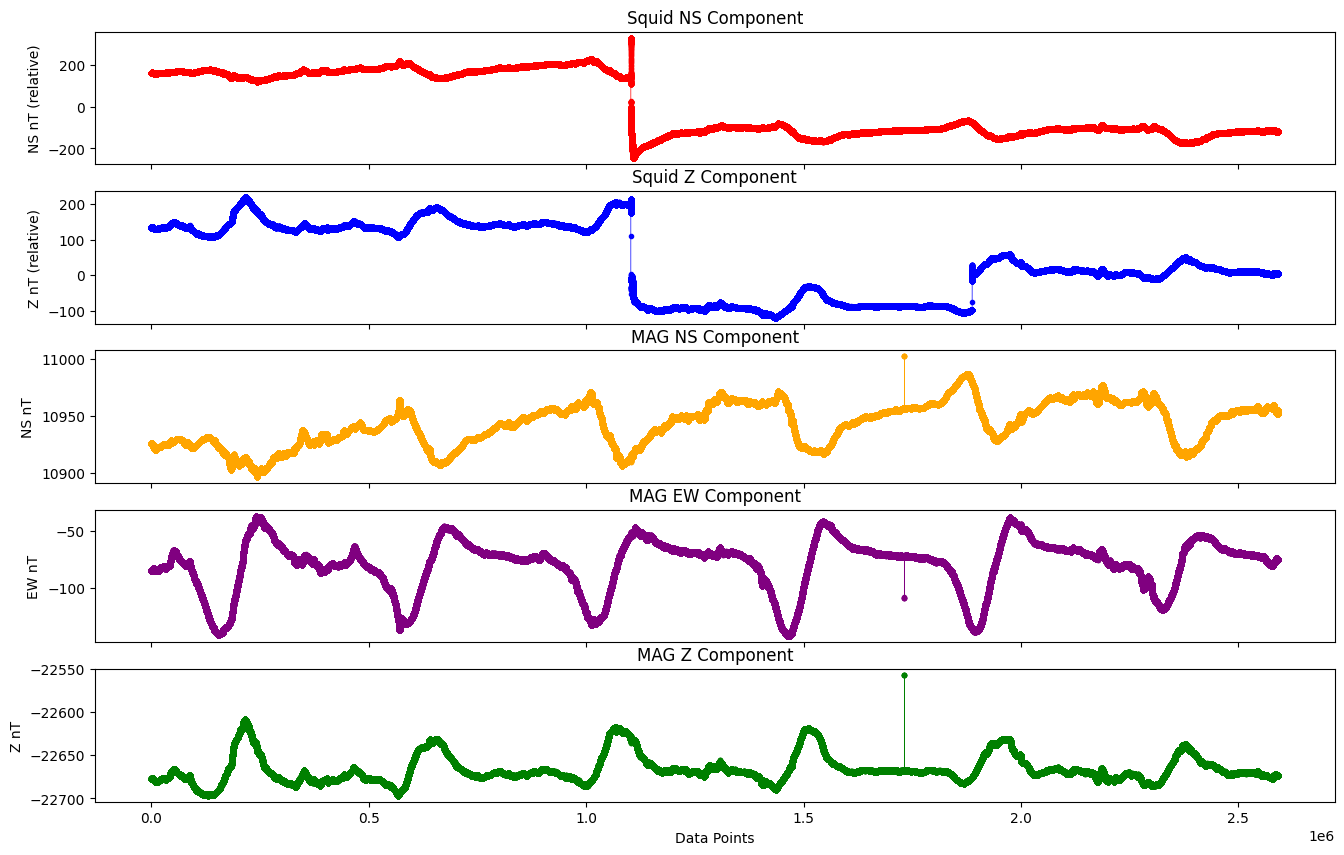

In [11]:
start_date_quiet = '2024-03-26'
end_date_quiet = '2024-03-31'

data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date_quiet, end_date_quiet))
data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date_quiet, end_date_quiet))
df_quiet = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date_quiet)
df_quiet = df_quiet.astype({'NS_SQUID': 'float32', 'Z_SQUID': 'float32', 'NS_Fluxgate': 'float32', 'EW_Fluxgate': 'float32', 'Z_Fluxgate': 'float32'})
del data_arr_mag, data_arr_squid
gc.collect()
# df = df.between_time('12:30:00', '13:30:00') # Select only a small subset of the data for analysis
# print(f' \n Shape of df', df.shape)
print(f' \nNumber of days data = Total records {df_quiet.shape[0]} / records per day (431998) = {df_quiet.shape[0]/431998} ')
print(f' \nHead of dataframe: \n', df_quiet.head().to_string(index=True))


Calculate offset

In [ ]:
columns  = ["NS_SQUID","Z_SQUID"]
for column in df_quiet.columns:
    feature_mean = df_quiet[column].mean()


# Standardise the dataset

Using Z-Score

New head after standardize                          NS_SQUID   Z_SQUID  NS_Fluxgate  EW_Fluxgate  \
2024-03-21 15:15:10.540 -0.057609  0.019418    -0.014468     1.629519   
2024-03-21 15:15:10.740 -0.057586  0.019428    -0.014849     1.629145   
2024-03-21 15:15:10.940 -0.057536  0.019328    -0.014849     1.629145   
2024-03-21 15:15:11.140 -0.057566  0.019396    -0.014987     1.629096   
2024-03-21 15:15:11.340 -0.057525  0.019080    -0.015195     1.630922   

                         Z_Fluxgate  
2024-03-21 15:15:10.540    0.563442  
2024-03-21 15:15:10.740    0.563273  
2024-03-21 15:15:10.940    0.563273  
2024-03-21 15:15:11.140    0.563104  
2024-03-21 15:15:11.340    0.562850  


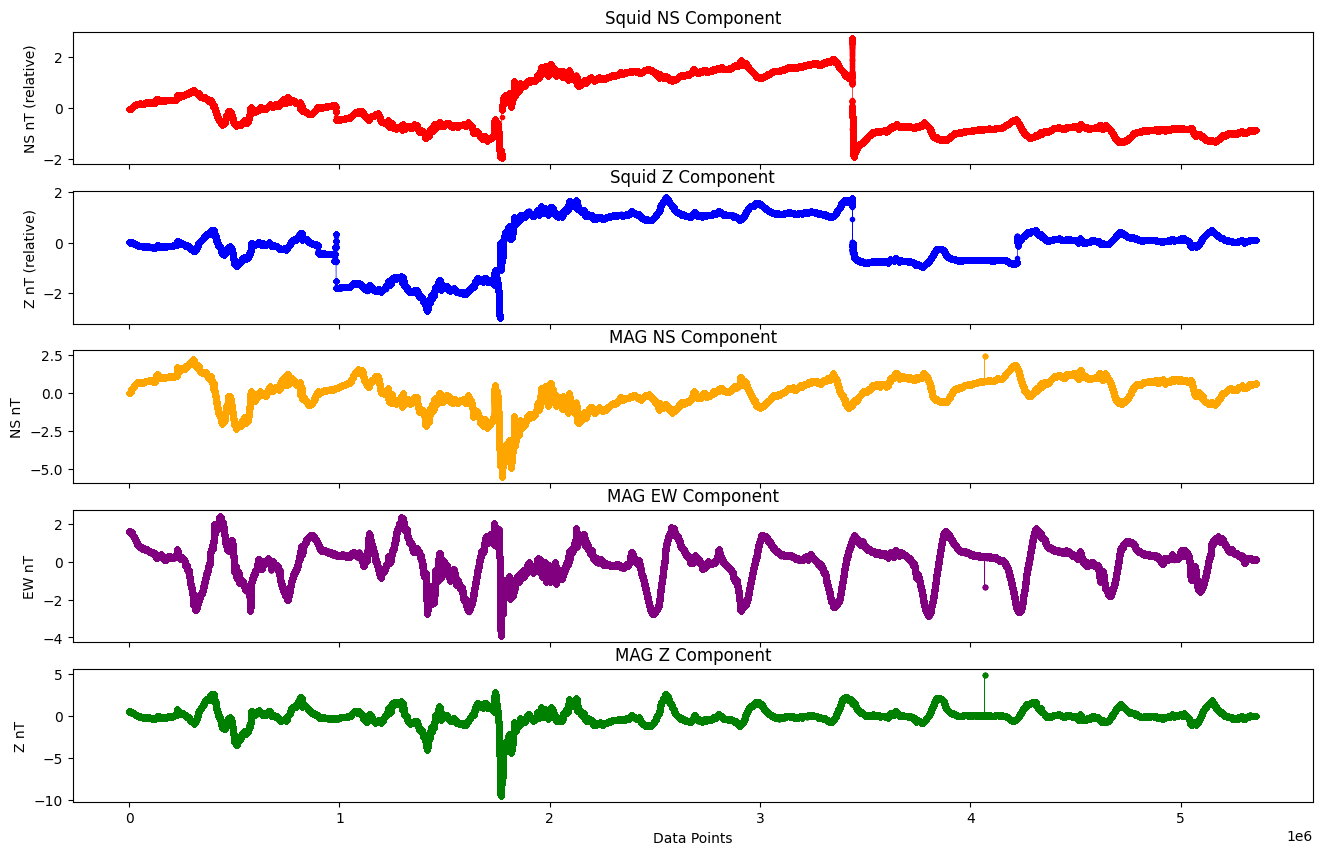

In [21]:
for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

print(f'New head after standardize', df.head())
eda.generateDataPlots(df['NS_SQUID'].values, df['Z_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 431997, start_date, end_date)

### Check for missing values and zero values

In [22]:
for column in df.columns:
    print(f"\n Number of missing values in {column} is: ", df[column].isna().sum())
    print(f"Nmber of zeros in {column} is: ", (df[column] == 0).sum())


 Number of missing values in NS_SQUID is:  0
Nmber of zeros in NS_SQUID is:  0

 Number of missing values in Z_SQUID is:  0
Nmber of zeros in Z_SQUID is:  0

 Number of missing values in NS_Fluxgate is:  0
Nmber of zeros in NS_Fluxgate is:  73

 Number of missing values in EW_Fluxgate is:  0
Nmber of zeros in EW_Fluxgate is:  0

 Number of missing values in Z_Fluxgate is:  0
Nmber of zeros in Z_Fluxgate is:  460


### Outlier Test

Z score test

 
 Shape of df before removing outliers (5360014, 5)
                                Z_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate
2024-03-21 15:15:10.540000000  0.019418     0.014401     1.629521    0.563382
2024-03-21 15:15:10.740000000  0.019428     0.014781     1.629147    0.563213
2024-03-21 15:15:10.940000000  0.019328     0.014781     1.629147    0.563213
2024-03-21 15:15:11.140000000  0.019396     0.014920     1.629098    0.563043
2024-03-21 15:15:11.340000000  0.019080     0.015128     1.630925    0.562789
...                                 ...          ...          ...         ...
2024-03-22 17:32:39.070000001  0.092197     0.611627     0.118291    0.013429
2024-03-22 17:32:39.270000001  0.092246     0.611627     0.118291    0.013429
2024-03-22 17:32:39.470000001  0.092253     0.611073     0.123570    0.013006
2024-03-22 17:32:39.670000001  0.092281     0.611073     0.123570    0.013006
2024-03-22 17:32:39.870000001  0.092257     0.611177     0.123957    0.014360

[5360014 r

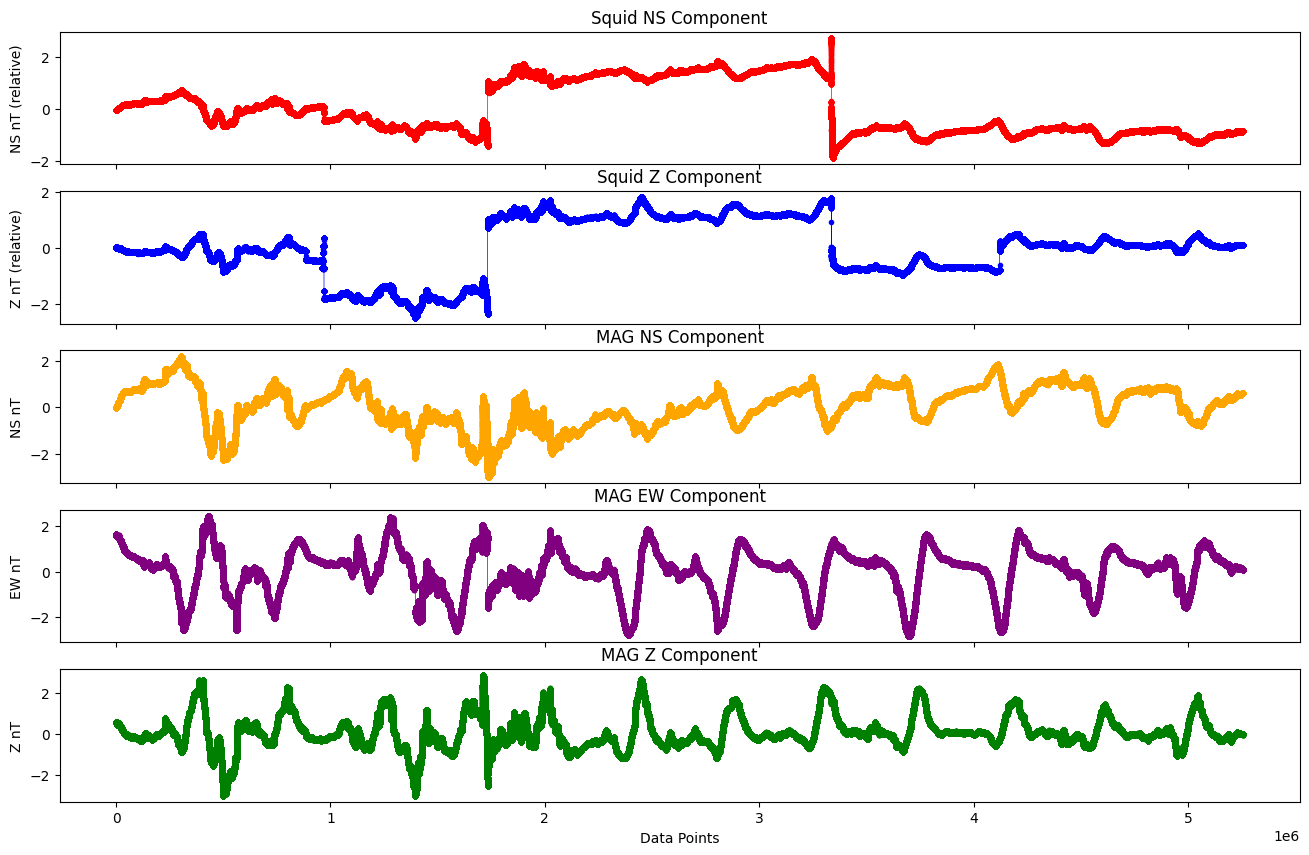

In [23]:
print(f' \n Shape of df before removing outliers', df.shape)
outliers_removed_z = eda.z_score_test(df)
print(f' \n Shape of df after removing outliers', outliers_removed_z.shape)
print(f'\nProportion of outliers removed:', (1-outliers_removed_z.shape[0]/df.shape[0])*100, '%')
del df
gc.collect()
eda.generateDataPlots(outliers_removed_z['NS_SQUID'].values, outliers_removed_z['Z_SQUID'].values, outliers_removed_z['NS_Fluxgate'].values, outliers_removed_z['EW_Fluxgate'].values, outliers_removed_z['Z_Fluxgate'].values, outliers_removed_z.shape[0], 431997, start_date, end_date)

### Fix sudden jumps or drops in the data

As we can see there are severe drops in the squid data. Lets fix these

DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
No spikes detected.


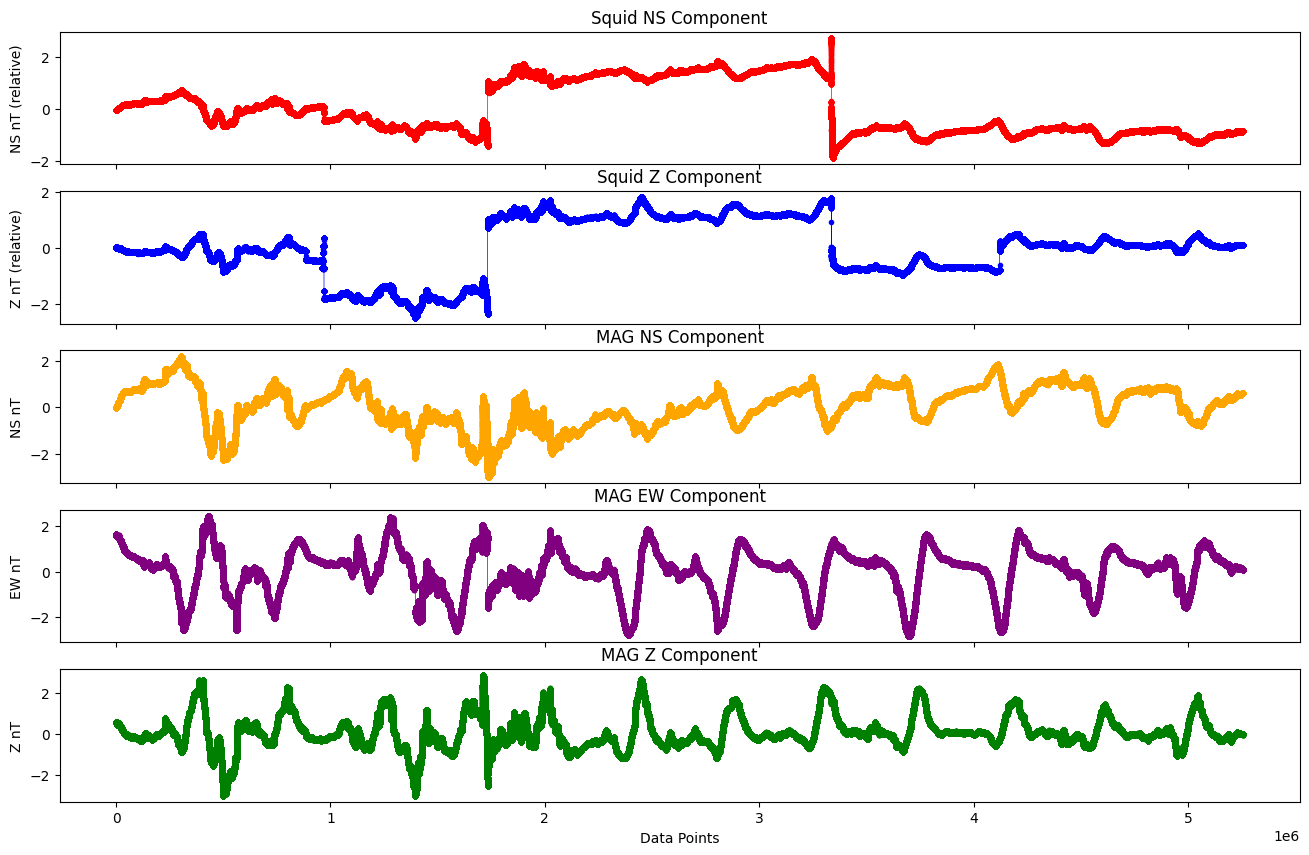

In [24]:
corrected_df_ns = eda.detect_spikes_and_correct(outliers_removed_z, "NS_SQUID")
corrected_df_f = eda.detect_spikes_and_correct(corrected_df_ns, "Z_SQUID")
corrected_df_nf = eda.detect_spikes_and_correct(corrected_df_f, "NS_Fluxgate")
corrected_df_ew = eda.detect_spikes_and_correct(corrected_df_nf, "EW_Fluxgate")
corrected_df = eda.detect_spikes_and_correct(corrected_df_ew, "Z_Fluxgate")
del outliers_removed_z, corrected_df_ns, corrected_df_f, corrected_df_nf, corrected_df_ew
gc.collect()
eda.generateDataPlots(corrected_df['NS_SQUID'].values, corrected_df['Z_SQUID'].values, corrected_df['NS_Fluxgate'].values, corrected_df['EW_Fluxgate'].values, corrected_df['Z_Fluxgate'].values, corrected_df.shape[0], 431997, start_date, end_date)

# Feature Generation

Now add the H component

In [25]:
h_component = np.sqrt(corrected_df['NS_Fluxgate']**2 + corrected_df['EW_Fluxgate']**2)
corrected_df.loc[:,"H Component"] = h_component
print(corrected_df)

                               NS_SQUID   Z_SQUID  NS_Fluxgate  EW_Fluxgate  \
2024-03-21 15:15:10.540000000 -0.057609  0.019418    -0.014468     1.629519   
2024-03-21 15:15:10.740000000 -0.057586  0.019428    -0.014849     1.629145   
2024-03-21 15:15:10.940000000 -0.057536  0.019328    -0.014849     1.629145   
2024-03-21 15:15:11.140000000 -0.057566  0.019396    -0.014987     1.629096   
2024-03-21 15:15:11.340000000 -0.057525  0.019080    -0.015195     1.630922   
...                                 ...       ...          ...          ...   
2024-03-22 17:32:39.070000001 -0.861666  0.092197     0.611559     0.118289   
2024-03-22 17:32:39.270000001 -0.861680  0.092246     0.611559     0.118289   
2024-03-22 17:32:39.470000001 -0.861691  0.092253     0.611006     0.123568   
2024-03-22 17:32:39.670000001 -0.861715  0.092281     0.611006     0.123568   
2024-03-22 17:32:39.870000001 -0.861734  0.092257     0.611109     0.123955   

                               Z_Fluxgate  H Compon

# Now Resample

 
 Shape of incoming dataframe (5257445, 6)
Shape of new resampled dataframe is: (350497, 6)
The number of records we should have is: 350496


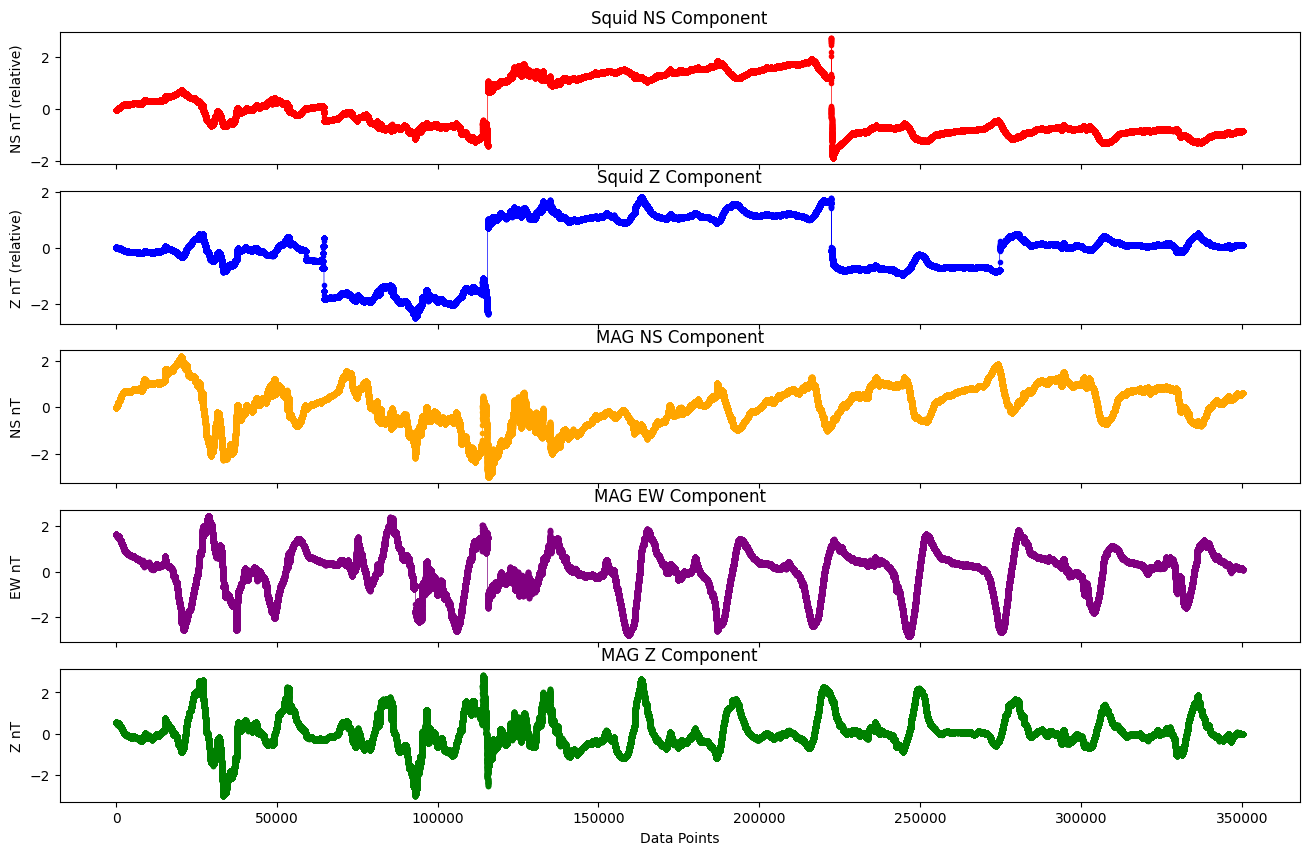

In [26]:
print(f' \n Shape of incoming dataframe', corrected_df.shape)
resampled_df = eda.calculate_mean_of_five(corrected_df)
print(f"Shape of new resampled dataframe is:", resampled_df.shape)
print(f"The number of records we should have is: {round(corrected_df.shape[0]/15)}")
del corrected_df
gc.collect()
eda.generateDataPlots(resampled_df['NS_SQUID'].values, resampled_df['Z_SQUID'].values, resampled_df['NS_Fluxgate'].values, resampled_df['EW_Fluxgate'].values, resampled_df['Z_Fluxgate'].values, resampled_df.shape[0], 86400, start_date, end_date)

Test for stationarity

In [27]:
eda.perform_dickey_fuller_test(resampled_df)

KeyboardInterrupt: 

Test for seasonality and trend

Analyzing column: NS_SQUID


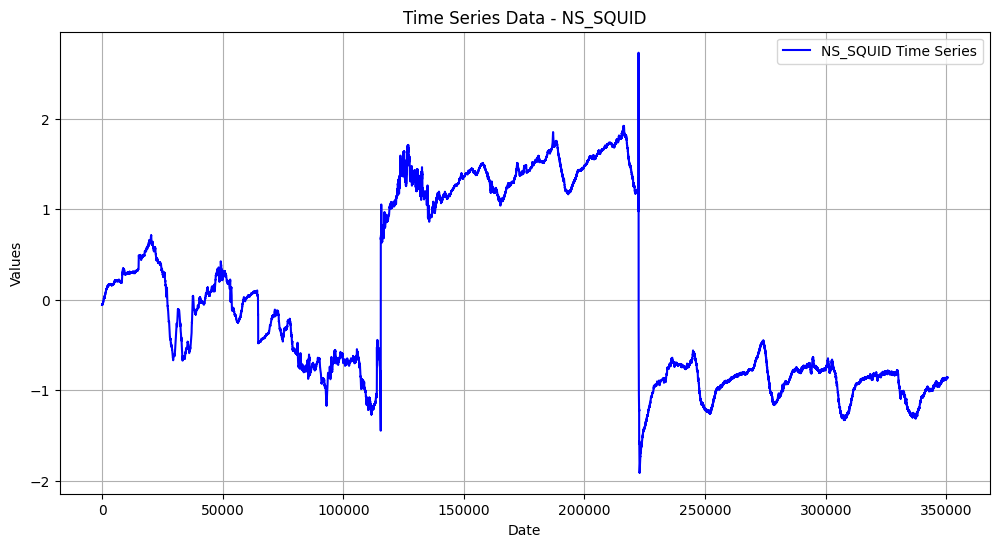

Decomposing the time series for column: NS_SQUID
Error decomposing NS_SQUID: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: Z_SQUID


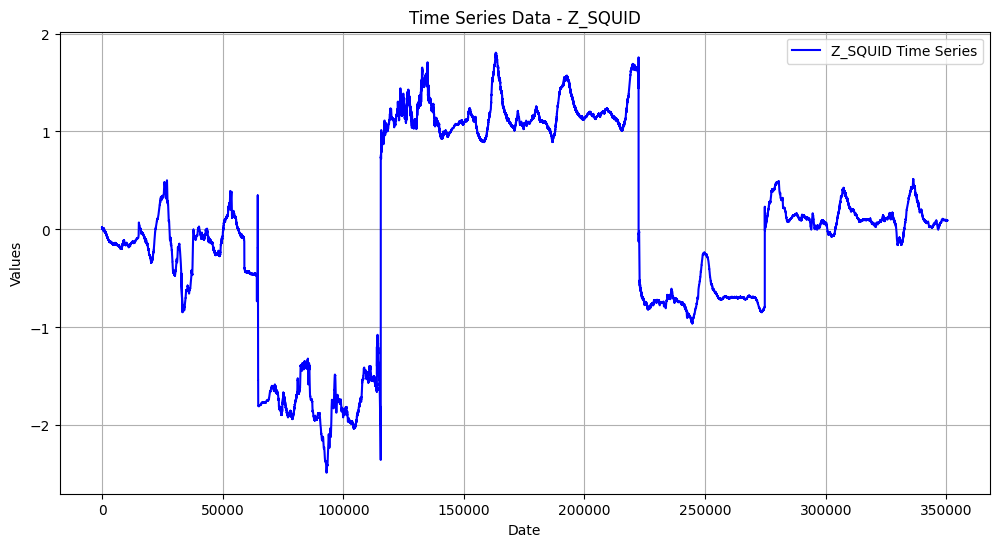

Decomposing the time series for column: Z_SQUID
Error decomposing Z_SQUID: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: NS_Fluxgate


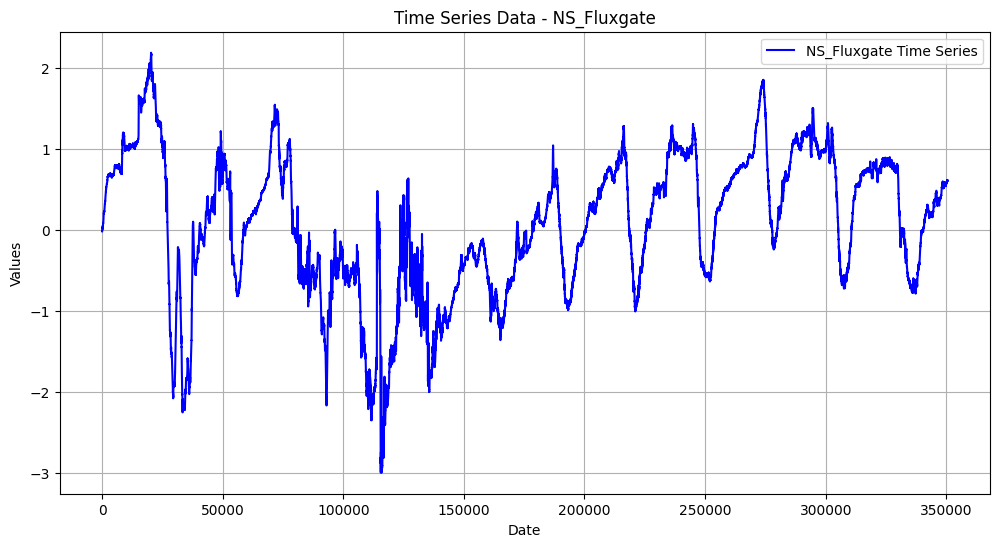

Decomposing the time series for column: NS_Fluxgate
Error decomposing NS_Fluxgate: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: EW_Fluxgate


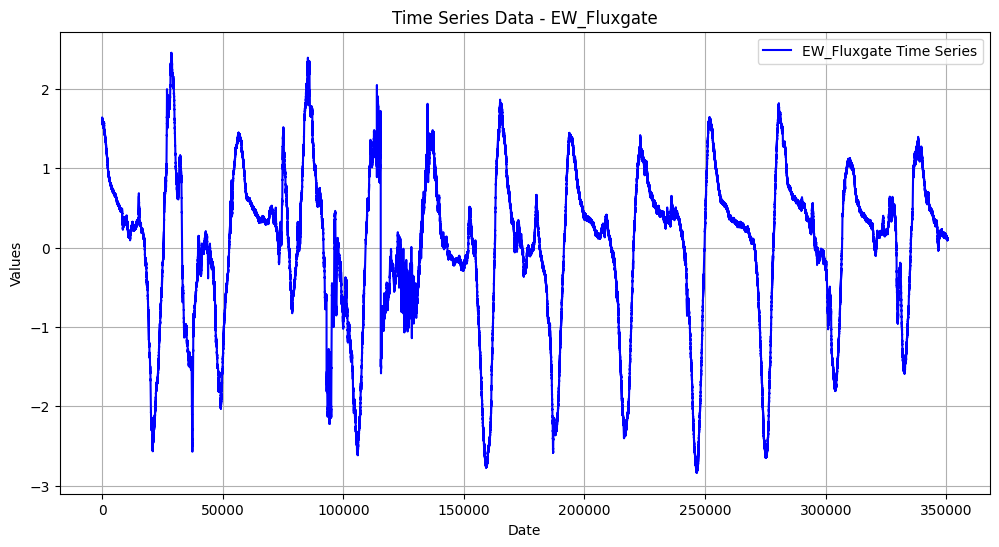

Decomposing the time series for column: EW_Fluxgate
Error decomposing EW_Fluxgate: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: Z_Fluxgate


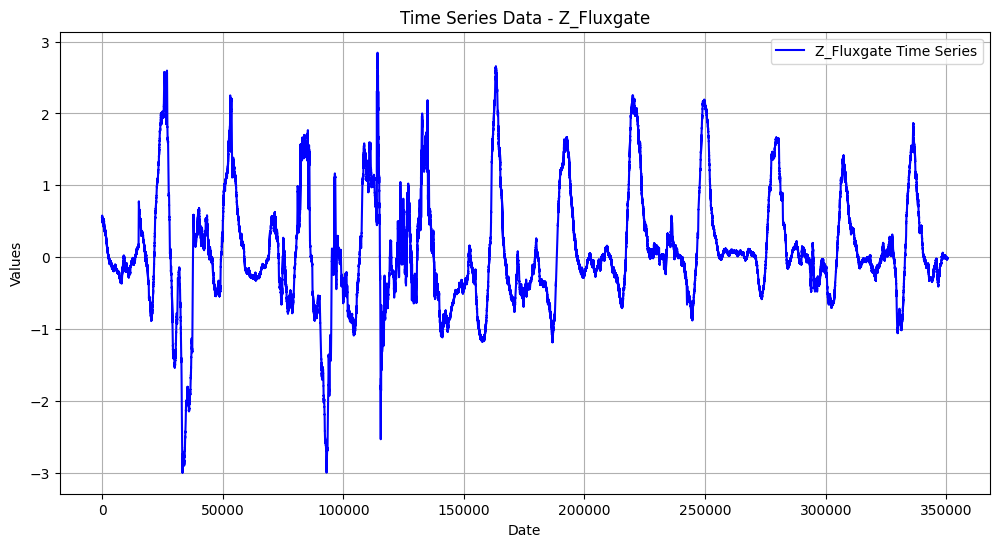

Decomposing the time series for column: Z_Fluxgate
Error decomposing Z_Fluxgate: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Analyzing column: H Component


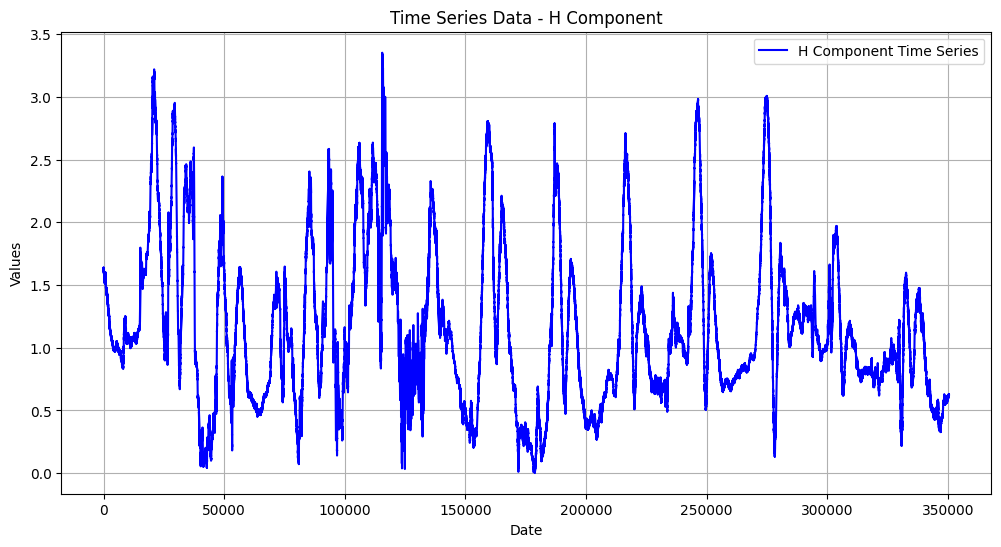

Decomposing the time series for column: H Component
Error decomposing H Component: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None


{}

In [28]:
eda.test_stationarity(resampled_df)

Now using the autocorrelation_plot

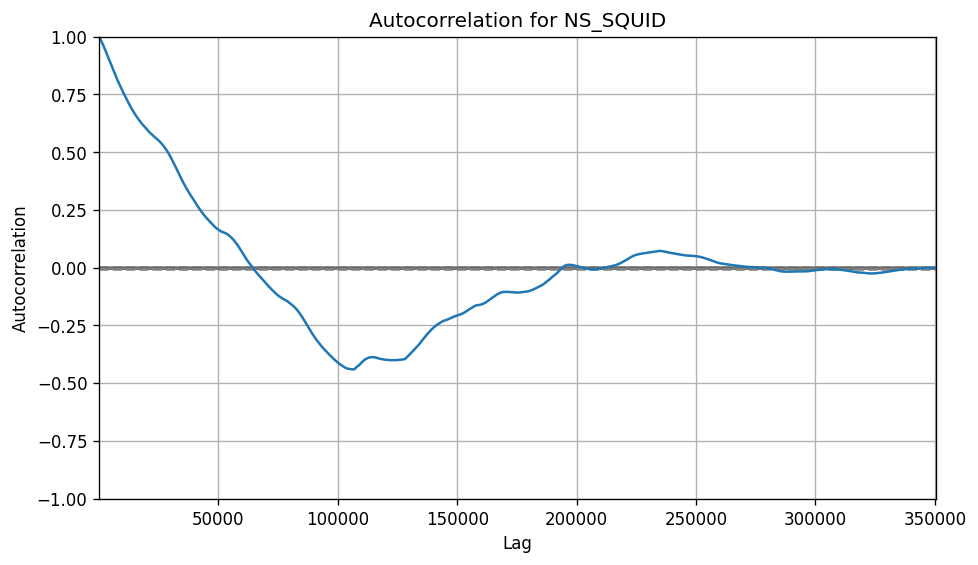

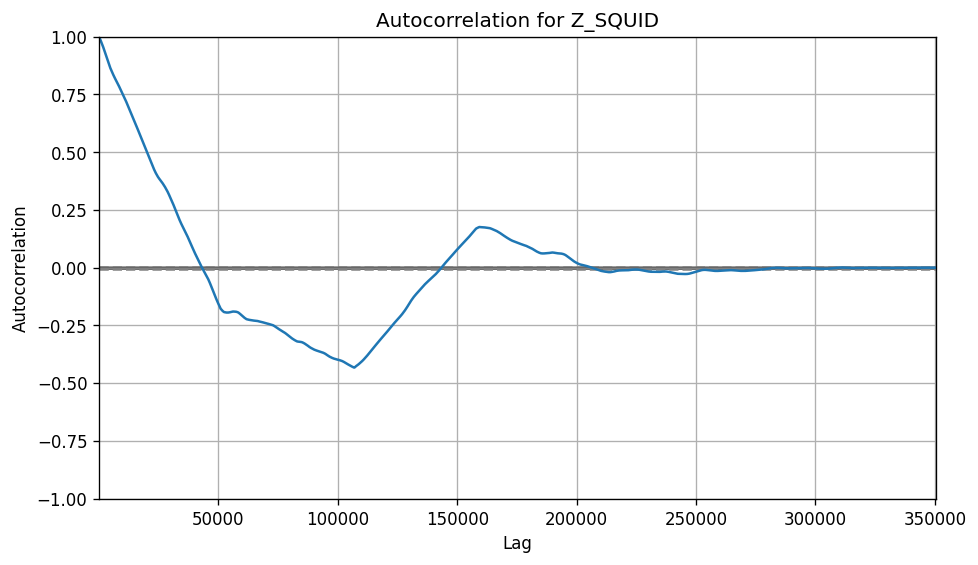

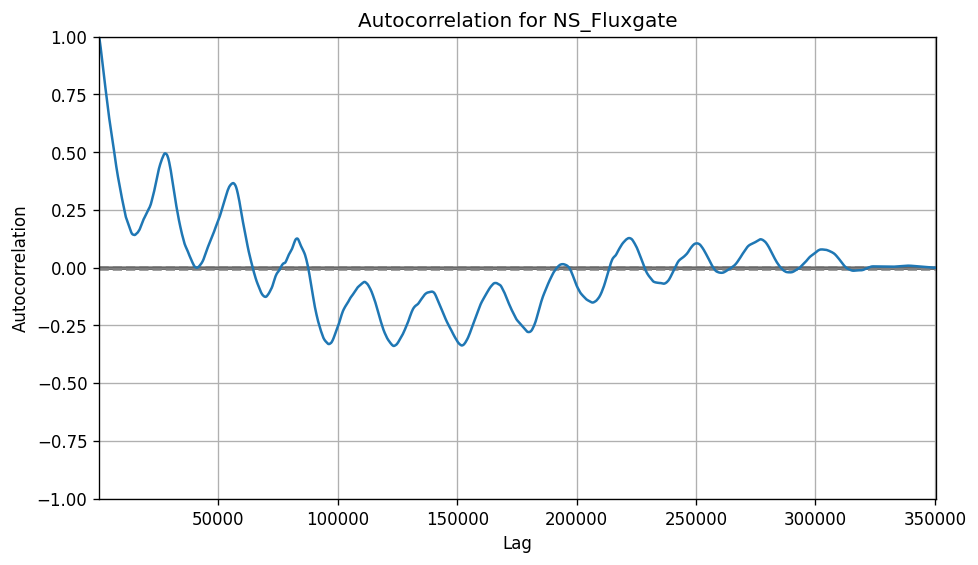

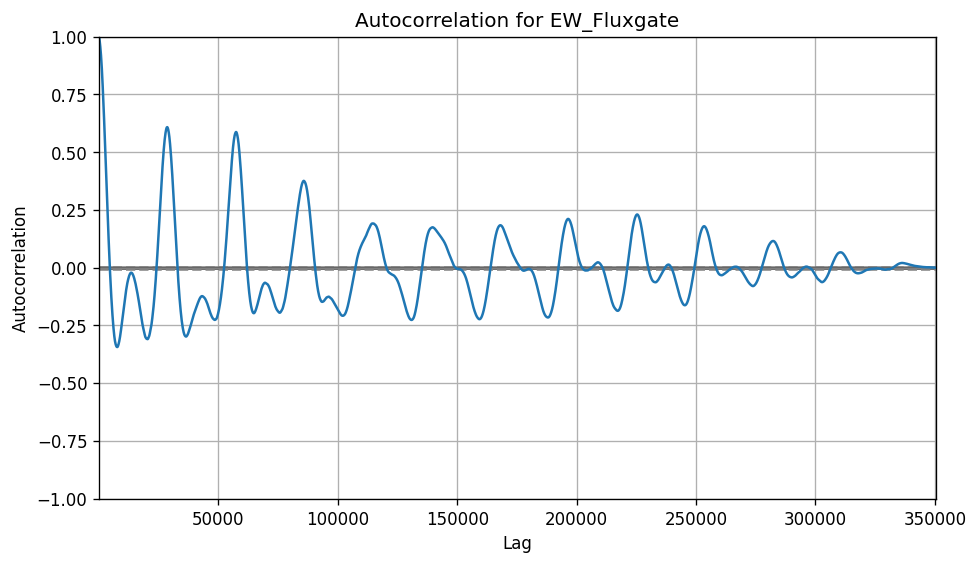

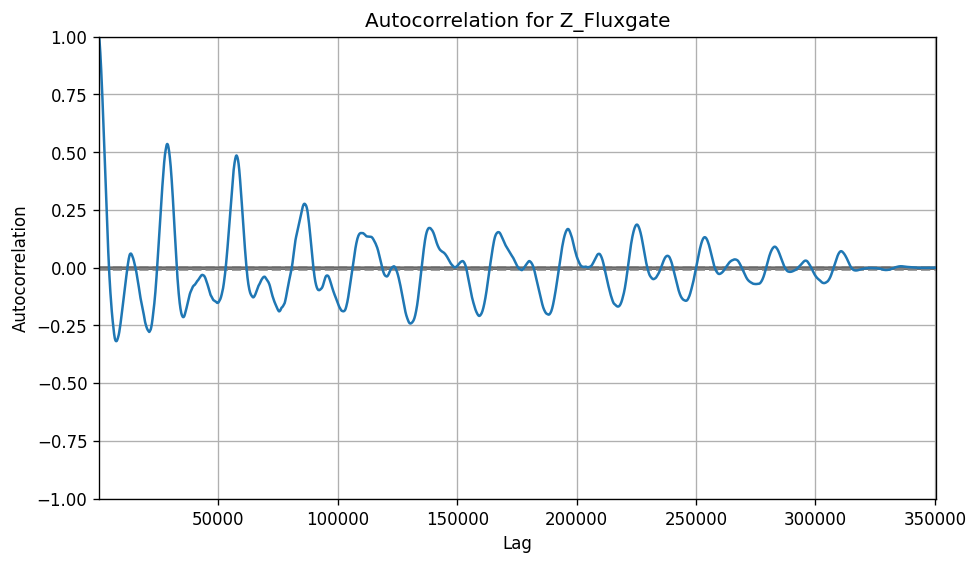

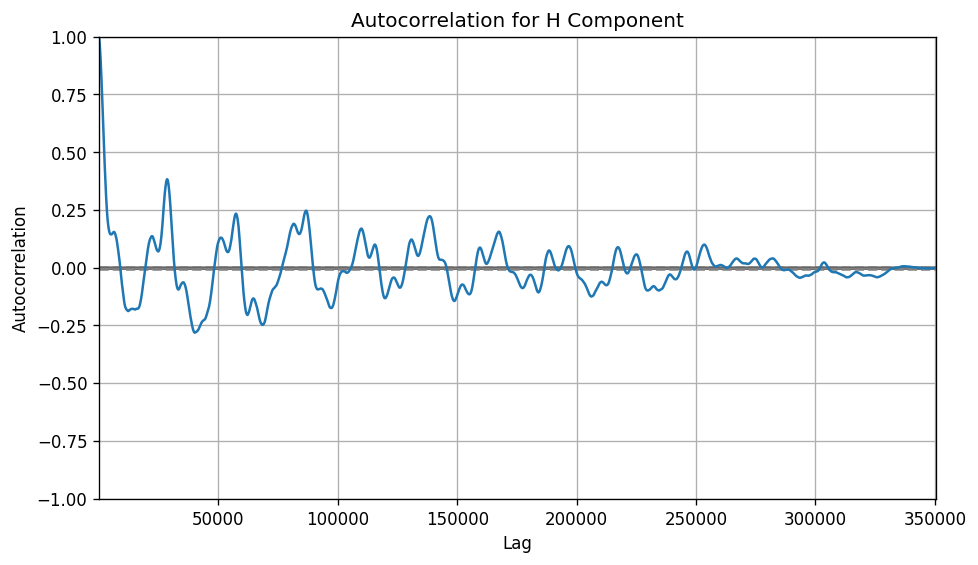

In [29]:
# Draw Plot
for column in resampled_df.columns:
    plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
    autocorrelation_plot(resampled_df[column].tolist())
    plt.title(f'Autocorrelation for {column}')
    plt.show()  # Display the plot

Fourier Transform

In [ ]:
components, fourier_results = eda.calculate_fourier_transforms(df)
eda.plot_fourier_transform(fourier_results, components)

Create PDF of each feature

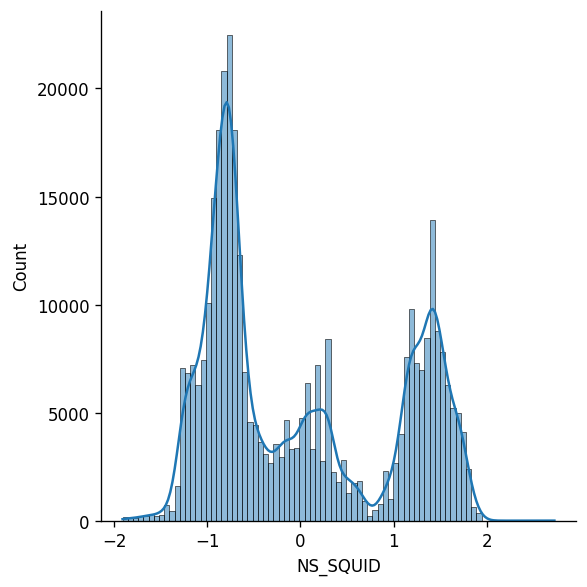

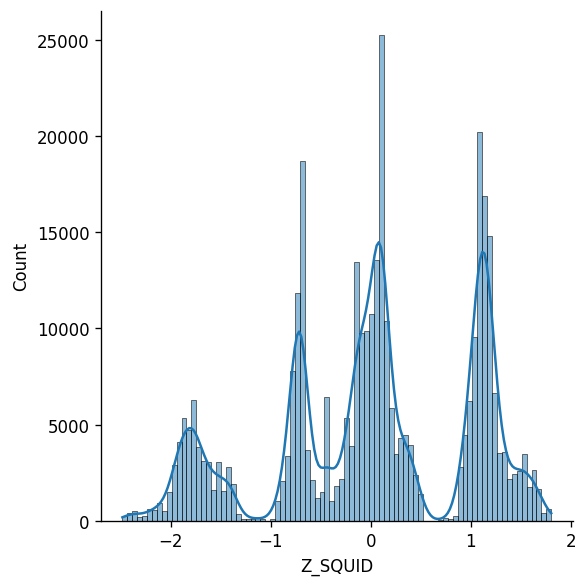

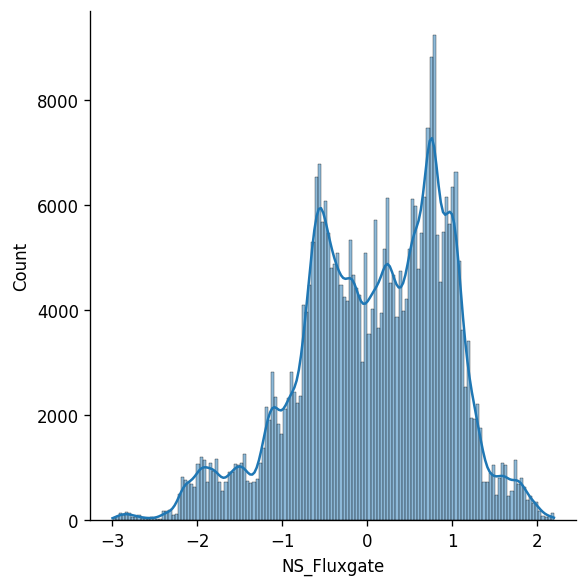

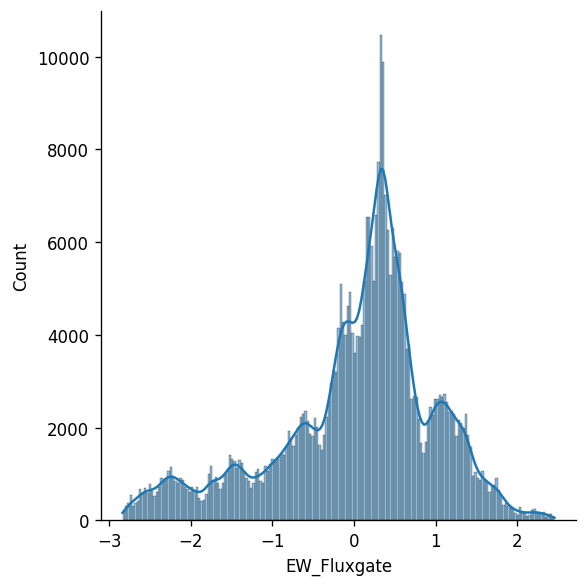

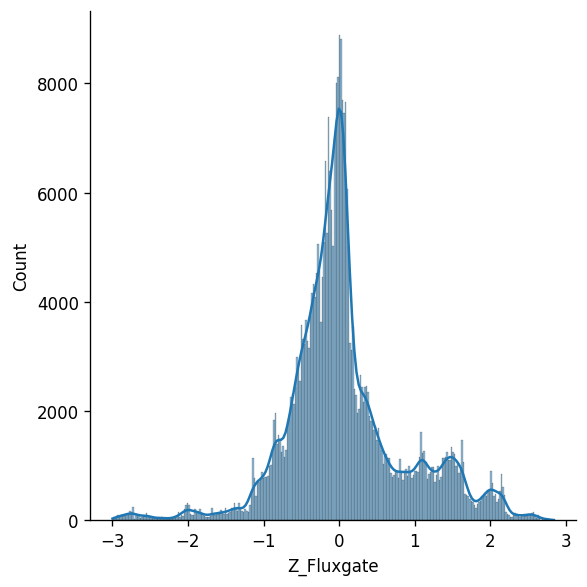

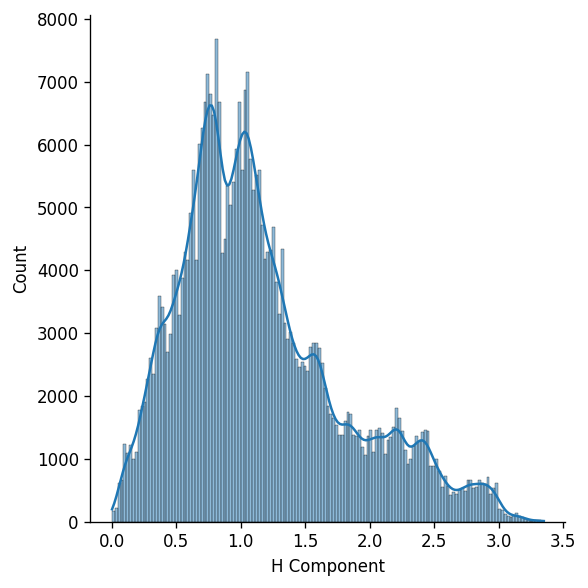

In [30]:
import seaborn as sns

for column in resampled_df.columns:
    sns.displot(resampled_df[column], kde=True)

Perform Decomposition

In [ ]:
# Additive Decomposition
# result_add = seasonal_decompose(df['Z_Fluxgate'], model='additive', extrapolate_trend='freq')

# Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()

Write the preprocessed dataframe to a file

In [32]:
resampled_df.to_csv('/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/RESAMPLED/{}-{}.csv'.format(start_date, end_date), index=True)
